In [ ]:
!pip install sklearn
!pip install quantulum3
!pip install transformers==3.5.0
!pip install nltk

In [ ]:
import os
import re
import io
import pandas as pd
import ast 
import numpy as np
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel, BertForPreTraining
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split

from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
from torchtext import vocab
from torchtext import data    
import torch.nn.functional as F

from torch.utils.data import TensorDataset, DataLoader

import nltk
from sklearn.model_selection import train_test_split
import re
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/My Drive/MeasEval-main/data/train/train/tsv

/content/drive/My Drive/MeasEval-main/data/train/train/tsv


In [ ]:
files=os.listdir()

In [ ]:
cd /content/drive/My Drive/MeasEval-main/data/train/dev/tsv

/content/drive/My Drive/MeasEval-main/data/train/dev/tsv


In [ ]:
val=os.listdir()

In [ ]:
cd ..

/content/drive/My Drive/MeasEval-main/data/train/dev


In [ ]:
cd ..

/content/drive/My Drive/MeasEval-main/data/train


In [ ]:
tokeniz = BertTokenizer.from_pretrained('bert-base-uncased')
mdl = BertModel.from_pretrained('bert-base-uncased', return_dict=True)

In [ ]:
def tokenize_and_preserve_labels(sentence, text_labels, tokenizer):

    """
    Word piece tokenization makes it difficult to match word labels
    back up with individual word pieces. This function tokenizes each
    word one at a time so that it is easier to preserve the correct
    label for each subword. It is, of course, a bit slower in processing
    time, but it will help our model achieve higher accuracy.
    """
    # print(len(sentence))
    # print(len(text_labels))
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)
    # print(len(tokenized_sentence))
    # print(len(labels))
    return tokenized_sentence, labels

In [ ]:
tok2idx = {}
tok2idx["Quantity"] = 1
tok2idx["MeasuredEntity"] = 2
tok2idx["MeasuredProperty"] = 3
tok2idx["Qualifier"]=4

In [ ]:
def data_read(path_to_file,text_path,model,tokenizer):
  y_train=[]
  l=0
  for i in path_to_file:
   #for j in :
     #i=path_to_file[j] 
    pathtxt=os.path.join(text_path,'text',i[:-3]+'txt')
    
    if (not os.path.isfile(pathtxt)):
      continue 
    
    with open(pathtxt, 'r') as f:
      text=f.read()
    pathtsv=os.path.join(text_path+'/tsv',i[:-3]+'tsv')
    if(not(os.path.exists(pathtsv))):
      continue
    filetsv=pd.read_csv(pathtsv,sep = '\t')
    data=filetsv[['annotType','startOffset','endOffset','text','annotId']]
    entity = data.to_numpy().tolist()
    tags={}
    ent=0
    offset=0
    sent_text = nltk.sent_tokenize(text)
    para=[]
    for j in sent_text:
      row=[]
      
      
      
      ent_sen=[]
      ret = [(m.group(0), m.start(), m.end() - 1) for m in re.finditer(r'\S+', j)]
      start=[]
      
      for word in ret:
        types=[]
        for ent_doc in entity:
          if(offset+word[1]>=ent_doc[1] and offset+word[2]<=ent_doc[2]):
            types.append(ent_doc[4])
            tags[ent_doc[4]]=np.zeros(768)
        ent_sen.append(types)     
      
      
      sen,label=tokenize_and_preserve_labels(j.split(' '),ent_sen,tokenizer)
      label.insert(0,[])
      label.append([])

      inputs = tokenizer(j, return_tensors="pt")
      outputs = model(**inputs)
      
      
      
      last_hidden_states = outputs.last_hidden_state
      
      for lbl in range(len(label)):
        for lbl2 in range(len(label[lbl])):
          if(label[lbl][lbl2] in tags):
            tags[label[lbl][lbl2]]+=last_hidden_states[0][lbl].detach().numpy()
          else:
            tags[label[lbl][lbl2]]=last_hidden_states[0][lbl].detach().numpy()
            
            

      offset+=(1+len(j))
      
      
    entity=filetsv[['annotType','annotId','startOffset','endOffset','text','other']]
    quant=entity[entity['annotType']!='Quantity']
    sent_text = nltk.sent_tokenize(text)
    quant=quant[['annotType','annotId','startOffset','endOffset','text','other']].to_numpy().tolist()
    paragraph=[]
    for qu in quant:
      other=qu[5]
      #print(qu)
      
      qu=qu[:-1]
      relation=[]
      if(not pd.isnull(other)):
        dictio=ast.literal_eval(other) 
        if 'HasQuantity' in dictio:
          id=dictio['HasQuantity']
          relation.append(qu[1])
          relation.append(id)
          relation.append(tok2idx[qu[0]])
          relation.append('HasQuantity')
          relation.append(1)
          
          
        if 'HasProperty' in dictio:
          id=dictio['HasProperty']
          relation.append(qu[1])
          relation.append(id)
          relation.append(tok2idx[qu[0]])
          relation.append('HasProperty')
          relation.append(3)
          
          
        if 'Qualifies' in dictio:
          id=dictio['Qualifies']          
          relation.append(qu[1])
          relation.append(id)
          relation.append(tok2idx[qu[0]])
          relation.append('Qualifies')
          relation.append(1)
          
        
        paragraph.append(relation)
    
    key=list(tags.keys())
    
    combinations=[] 
    for j in range(len(key)):
      for k in range(j+1,len(key)):
        combinations.append([key[j],key[k]])
    
    
    features=[]
    count=0
    
    for j in combinations:
      for k in paragraph:
        if((j[0]==k[0] and j[1]==k[1]) or (j[0]==k[1] and j[1]==k[0])):
          features.append([tags[j[0]],tags[j[1]],k[2],k[3],k[4]])
        elif(count<=5):
          features.append([tags[j[0]],tags[j[1]],k[2],"norelation",k[4]])
          count+=1
    y_train.append(features)
    
    
  return y_train
  
  
    
  
  
  
  


In [ ]:
y_train=data_read(files,'train',mdl,tokeniz)

In [ ]:
sab = {}

In [ ]:
print(len(y_train))

222


In [ ]:
sab["sab"] = np.zeros(4)

In [ ]:
y_val=data_read(val,'dev',mdl,tokeniz)

In [ ]:
len(y_val)

28

In [ ]:
X1=[]
X2=[]
X3=[]
X4 = []
relation=[]

In [ ]:
for i in range(len(y_train)):
  for j in range(len(y_train[i])):
    if(len(y_train[i][j])==5):
      X1.append(y_train[i][j][0])
      X2.append(y_train[i][j][1])
      X3.append(y_train[i][j][2])
      relation.append(y_train[i][j][3])
      X4.append(y_train[i][j][4])
    
    

In [ ]:
X1 = np.array(X1)
X2 = np.array(X2)
X3 = np.array(X3)
X4 = np.array(X4)

[1 1 2 ... 1 2 1]


In [ ]:
np.shape(X2)

(2760, 768)

In [ ]:
np.shape(X3)

(2760,)

In [ ]:
import numpy as np

In [ ]:
tok2idx = {}
tok2idx["HasProperty"] = 0
tok2idx["HasQuantity"] = 1
tok2idx["Qualifies"] = 2
tok2idx["norelation"]=3

In [ ]:
num = np.zeros((4,))
y_train = np.zeros((len(relation),4))
for i in range(len(relation)):
  num[tok2idx[relation[i]]] +=1
  for j in range(4):
    if tok2idx[relation[i]] == j:
      y_train[i][j] = 1
    else:
      y_train[i][j] = 0
  

In [ ]:
num = num/np.sum(num)

In [ ]:
num = 1/num

In [ ]:
print(num[0])
print(num[1])
print(num[2])
print(num[3])

5.19774011299435
3.4716981132075473
11.21951219512195
2.323232323232323


In [ ]:
y_train

array([[0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]])

In [ ]:
np.shape(y_train)

(2760, 4)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
inputA = layers.Input(shape=(768,))
inputB = layers.Input(shape=(768,))
inputC = layers.Input(shape=(1,))
inputD = layers.Input(shape = (1,))

x = layers.Dense(128, activation="relu")(inputA)
x = layers.Dense(64, activation="relu")(x)

y = layers.Dense(128, activation="relu")(inputB)
y = layers.Dense(64, activation="relu")(y)

c = layers.Dense(1, activation="relu")(inputC)

d = layers.Dense(1, activation="relu")(inputD)


com = layers.concatenate([x, y, c, d])
z = layers.Dense(32, activation="relu")(com)
z = layers.Dense(4,  activation='softmax')(z)
model = keras.Model(inputs=[inputA, inputB, inputC, inputD], outputs=z)

In [ ]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 768)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 768)]        0                                            
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 128)          98432       input_5[0][0]                    
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 128)          98432       input_6[0][0]                    
_______________________________________________________________________________________

In [ ]:
from keras import backend as K
def weighted_categorical_crossentropy(weights):

    weights = K.variable(weights)
        
    def loss(y_true, y_pred):

        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)

        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())

        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss

In [ ]:
fact = 3
weights = [num[0]*fact,num[1]*fact,num[2]*fact,num[3]]

In [ ]:
weights

[15.593220338983052, 10.415094339622641, 33.65853658536585, 2.323232323232323]

In [ ]:
model.compile(optimizer='adam',
              loss= weighted_categorical_crossentropy(weights),
              metrics=['accuracy'])

In [ ]:
precision = []
recall = []
F1 = []
epoch = []
step = 10
for i in range(10):
  model.fit(x = [X1,X2,X3,X4], y = y_train, epochs=step, batch_size=32)
  p,r,f = pred()
  precision.append(p)
  recall.append(r)
  F1.append(f)
  epoch.append((i+1)*step)

Epoch 1/10
87/87 [==============================] - 0s 3ms/step - loss: 0.8749 - accuracy: 0.8793
Epoch 2/10
87/87 [==============================] - 0s 3ms/step - loss: 0.7545 - accuracy: 0.8942
Epoch 3/10
87/87 [==============================] - 0s 3ms/step - loss: 0.7331 - accuracy: 0.8935
Epoch 4/10
87/87 [==============================] - 0s 3ms/step - loss: 0.7331 - accuracy: 0.8909
Epoch 5/10
87/87 [==============================] - 0s 4ms/step - loss: 0.7209 - accuracy: 0.8844
Epoch 6/10
87/87 [==============================] - 0s 4ms/step - loss: 0.7102 - accuracy: 0.8909
Epoch 7/10
87/87 [==============================] - 0s 3ms/step - loss: 0.7229 - accuracy: 0.8924
Epoch 8/10
87/87 [==============================] - 0s 3ms/step - loss: 0.7122 - accuracy: 0.8949
Epoch 9/10
87/87 [==============================] - 0s 3ms/step - loss: 0.7175 - accuracy: 0.8884
Epoch 10/10
87/87 [==============================] - 0s 3ms/step - loss: 0.7185 - accuracy: 0.8942
Epoch 1/10
87/87 [=

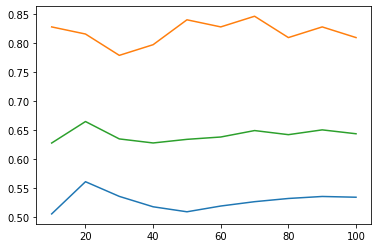

In [ ]:
import matplotlib.pyplot as plt
plt.plot(epoch,precision)
plt.plot(epoch,recall)
plt.plot(epoch,F1)
plt.show()

In [ ]:
model.fit(x = [X1,X2,X3,X4], y = y_train, epochs=5, batch_size=32)

IndexError: ignored

In [ ]:
X1_val=[]
X2_val=[]
X3_val=[]
relation_val=[]
X4_val=[]

In [ ]:
for i in range(len(y_val)):
  for j in range(len(y_val[i])):
    if(len(y_val[i][j])==5):
      X1_val.append(y_val[i][j][0])
      X2_val.append(y_val[i][j][1])
      X3_val.append(y_val[i][j][2])
      relation_val.append(y_val[i][j][3]) 
      X4_val.append(y_val[i][j][4])  

In [ ]:
relation_val2 = np.zeros(len(relation_val))

for i in range(len(relation_val)):
  relation_val2[i]=tok2idx[relation_val[i]]

X1_val = np.array(X1_val)
X2_val = np.array(X2_val)
X3_val = np.array(X3_val)
X4_val = np.array(X4_val)

In [ ]:
def pred():
  y_pred=model.predict([X1_val,X2_val,X3_val,X4_val])
  y_output=np.argmax(y_pred,axis=-1)
  count=0
  total=0
  p1=0
  t1=0
  p2=0
  t2=0
  for i in range(len(y_output)):
    if y_output[i]<=2 and relation_val2[i]<=2:
      if y_output[i]==relation_val2[i]:
        count+=1
      total+=1
    if y_output[i]<=2:
      if y_output[i]==relation_val2[i]:
        p1+=1
      t1+=1
    if relation_val2[i]<=2:
      if y_output[i]==relation_val2[i]:
        p2+=1
      t2+=1
  prec = p1/t1
  rec = p2/t2
  f1 = 2*prec*rec/(prec+rec)
  return prec,rec,f1


In [ ]:
y_pred=model.predict([X1_val,X2_val,X3_val,X4_val])

In [ ]:
y_output=np.argmax(y_pred,axis=-1)

In [ ]:
count=0
total=0
p1=0
t1=0
p2=0
t2=0
for i in range(len(y_output)):
  if y_output[i]<=2 and relation_val2[i]<=2:
    if y_output[i]==relation_val2[i]:
      count+=1
    total+=1
  if y_output[i]<=2:
    if y_output[i]==relation_val2[i]:
      p1+=1
    t1+=1
  if relation_val2[i]<=2:
    if y_output[i]==relation_val2[i]:
      p2+=1
    t2+=1
prec = p1/t1
rec = p2/t2

In [ ]:
print("Accuracy " + str(count/total))
print("Precision " + str(prec))
print("Recall " + str(rec))
print("F1 Score " + str(2*prec*rec/(prec+rec)))

Accuracy 0.9041095890410958
Precision 0.5344129554655871
Recall 0.8098159509202454
F1 Score 0.6439024390243904


In [ ]:
y_output

array([1, 3, 3, 0, 1, 2, 3, 3, 3, 2, 3, 3, 2, 2, 2, 0, 0, 2, 0, 0, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 3, 3, 0, 1, 3, 0,
       3, 0, 0, 3, 0, 1, 0, 1, 2, 0, 1, 1, 1, 3, 1, 3, 3, 1, 3, 0, 0, 1,
       2, 1, 0, 1, 1, 3, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 2, 1, 0, 3, 1,
       1, 3, 1, 3, 1, 3, 3, 1, 1, 0, 3, 3, 3, 1, 3, 3, 3, 0, 3, 0, 3, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 2, 1, 0, 1, 0, 1, 2, 0, 1,
       3, 0, 1, 3, 1, 2, 1, 1, 1, 1, 1, 1, 3, 0, 1, 3, 1, 3, 1, 3, 1, 0,
       1, 2, 1, 0, 1, 1, 0, 3, 0, 3, 0, 1, 1, 1, 2, 1, 3, 3, 3, 0, 1, 1,
       1, 3, 1, 3, 1, 3, 0, 1, 0, 1, 0, 0, 1, 1, 0, 2, 2, 0, 0, 2, 1, 2,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 3, 1, 1, 3, 1,
       0, 0, 1, 2, 3, 3, 3, 0, 3, 3, 3, 3, 2, 2, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 3, 2, 1, 3, 1, 2, 1, 2, 0, 0, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0,
       0, 0, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 0, 3, 0, 3, 3, 0, 0, 1,
       1, 0, 0, 1, 2, 1, 2, 1, 3, 1, 3, 3, 3, 1, 2,

In [ ]:
from collections import Counter

Counter(relation_val)

Counter({'HasProperty': 58,
         'HasQuantity': 90,
         'Qualifies': 15,
         'norelation': 148})

In [ ]:
model.save_weights('/content/drive/My Drive/Model/rel_wt_new.h5')

In [ ]:
model.save('/content/drive/My Drive/Model/rel_model.h5')

In [ ]:
from keras.models import load_model
model.load_weights('/content/drive/My Drive/Model/rel_model.h5')

ValueError: ignored

In [ ]:
model.load('/content/drive/My Drive/Model/rel_model.h5')